In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import entropy
from collections import defaultdict
from PIL import Image 
import random
import os
import time

In [75]:
class Grid:

    def __init__(self, M=15, N=15, P = 2, W = 21, B = 3):
        
        self.B = B 
        self.color = [0.2588, 0.4039, 0.6980]
        self.brightness = 1.8
        self.grid = []
        self.P = P
        self.W = W 
        self.M = M 
        self.N = N
        self.ew = self.W + P//2
        self.grid = self.generate_grid()
    
    def generate_grid(self):
        grid = []
        for i in range(self.M):
            row_i = []
            for j in range(self.N):
                grid_ij = np.ones((self.W+self.P, self.W+self.P, 3))
        
                for c in range(3):
                    grid_ij[:,:,c] = self.color[c]*(0.7 + (self.brightness - 0.9)/60*(i+30-j))
        
                #make white
                grid_ij[:self.P//2,:,:] = 0
                grid_ij[-self.P//2:,:,:] = 0

                grid_ij[:,:self.P//2,:] = 0
                grid_ij[:,-self.P//2:,:] = 0
                
                #append to row_i
                row_i.append(grid_ij)
        
            #append to grid
            grid.append(row_i)
        return grid

    def get_grid(self, x, y):
        grid = self.grid[self.M - y - 1][x]
        return grid 

    def draw_one_step_grid(self, sp, dp, grid, color):
        #print(sp, dp)
        if(sp[0] == dp[0]):

            grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],:] *= 0
            for c in range(3):
                grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],c] = color[c]
            #print(grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],0].shape)
        else:
            grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,:] *= 0
            for c in range(3):
                grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,c] = color[c]
            #print(grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,0].shape)
        
    def draw_one_step(self, sp, dp, color):

        delta_x = dp[0] - sp[0] 
        delta_y = dp[1] - sp[1]
        
        sgrid = self.get_grid(sp[0]-1, sp[1]-1) 
        dgrid = self.get_grid(dp[0]-1, dp[1]-1)
        if(delta_x == delta_y):
            return
        if(delta_x == -1):
            self.draw_one_step_grid((self.ew//2 + 1,0),(self.ew//2 + 1, self.ew//2+1), sgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.ew//2+1,self.W + self.P), dgrid, color)
            
        elif(delta_x == 1):
            self.draw_one_step_grid((self.ew//2+1, 0),(self.ew//2 + 1, self.ew//2 + 1), dgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.ew//2+1, self.W + self.P), sgrid, color)
        elif(delta_y == -1):
            self.draw_one_step_grid((0 ,self.ew//2 + 1),( self.ew//2 + 1, self.ew//2+1), dgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.W + self.P, self.ew//2+1), sgrid, color)
            
        elif(delta_y == 1):
            self.draw_one_step_grid((0, self.ew//2+1),(self.ew//2 + 1, self.ew//2 + 1), sgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.W + self.P,self.ew//2+1), dgrid, color)
            
        return

    def draw_path(self, sequence, color = [0,0,1]):

        start_x, start_y = sequence[0]
        start_grid = self.get_grid(start_x-1,start_y-1)
        start_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2] *= 0
        start_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2,0] += 1
        

        end_x, end_y = sequence[-1]
        end_grid = self.get_grid(end_x-1,end_y-1)
        end_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2] *= 0
        end_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2,1] += 1
        
        for i in range(1,len(sequence)):
            self.draw_one_step(sequence[i-1],sequence[i], color)
        
        
    
    def show(self, path = "demo.png"):

        grid = [np.concatenate(row_i, axis = 1) for row_i in self.grid]
        grid = np.concatenate(grid, axis = 0)
        grid = np.clip(grid, 0, 1)
        grid_big = np.zeros((grid.shape[0] + 2*self.B, grid.shape[1] + 2*self.B, 3))
        grid_big[:,:,0] = 1
        grid_big[:,:,1] = 1
        grid_big[self.B:-1*self.B,self.B:-1*self.B] = grid

        grid = (grid_big*255).astype('uint8')

        grid = Image.fromarray(grid)
        grid.save(path)
    
    def clear(self):
        self.grid = self.generate_grid()



In [76]:
grid = Grid()

# Sample Trajectories and Observations

In [96]:
def generate_trajectories(starting_point):
    tuples_list = [starting_point]
    movements = [(1, 0), (0, 1), (0, -1), (-1, 0), (0, 0)]
    base_probabilities = [0.4, 0.3, 0.1, 0.1, 0.1]

    for _ in range(29):
        i, j = tuples_list[-1]
        probabilities = base_probabilities.copy()
        
        if i + 1 > 15:  
            probabilities[4] += probabilities[0]  
            probabilities[0] = 0  
        if i - 1 < 1:  
            probabilities[4] += probabilities[3]  
            probabilities[3] = 0  
        if j + 1 > 15:  
            probabilities[4] += probabilities[1]  
            probabilities[1] = 0  
        if j - 1 < 1:  
            probabilities[4] += probabilities[2]  
            probabilities[2] = 0  

        move = random.choices(movements, probabilities)[0]
        new_tuple = (i + move[0], j + move[1])
        tuples_list.append(new_tuple)
    
    return tuples_list

starting_points = [(1, 1)]
trajectories = []
start_points = []
end_points = []

for point in starting_points:
    for _ in range(20):
        trajectory = generate_trajectories(point)
        trajectories.append(trajectory)
        start_points.append(trajectory[0])
        end_points.append(trajectory[-1])

for idx, trajectory in enumerate(trajectories):
    print(f"Trajectory {idx+1}: {trajectory}")
    print(f"  Start Point: {start_points[idx]}")
    print(f"  End Point: {end_points[idx]}")
    print("-" * 50)

Trajectory 1: [(1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (2, 5), (3, 5), (3, 4), (3, 5), (4, 5), (5, 5), (6, 5), (5, 5), (4, 5), (5, 5), (6, 5), (7, 5), (7, 6), (6, 6), (7, 6), (7, 5), (7, 6), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (8, 8), (8, 9)]
  Start Point: (1, 1)
  End Point: (8, 9)
--------------------------------------------------
Trajectory 2: [(1, 1), (1, 2), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (3, 3), (4, 3), (3, 3), (3, 2), (3, 3), (3, 4), (4, 4), (4, 5), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (9, 6), (9, 7), (9, 6), (10, 6), (11, 6), (12, 6), (12, 5), (13, 5), (13, 6), (13, 5)]
  Start Point: (1, 1)
  End Point: (13, 5)
--------------------------------------------------
Trajectory 3: [(1, 1), (1, 1), (1, 2), (1, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (3, 4), (4, 4), (4, 5), (4, 6), (5, 6), (5, 7), (4, 7), (4, 8), (5, 8), (6, 8), (6, 8), (7, 8), (8, 8), (8, 9), (8, 10), (9, 10), (9, 9), (10, 9), (10, 9), (11, 9), (12, 9)]
  Start Point: (1, 1)
  End Point: 

To check whether any point in the trajectories are out of bounds

In [97]:
grid_size = (15,15)
for trajectory in trajectories: 
    for i, (x, y) in enumerate(trajectory):
        if x < 1 or x > grid_size[0] or y < 1 or y > grid_size[1]:
            print(f"Point {i} in trajectory out of bounds: ({x}, {y})")

In [98]:
def plot_trajectory(trajectory, grid_size=(15, 15), save_path="trajectories", file_name="trajectory.png"):
    grid = Grid(M=grid_size[0], N=grid_size[1])
    #coordinates = [point[0] for point in trajectory]
    grid.draw_path(trajectory, [1,1,1])
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    full_path = os.path.join(save_path, file_name)
    grid.show(full_path)

for idx, trajectory in enumerate(trajectories):
    file_name = f"trajectory_{idx+1}.png"
    plot_trajectory(trajectory, save_path="trajectories", file_name=file_name)

print("Trajectories have been plotted and saved.")

Trajectories have been plotted and saved.


In [99]:
def sensor_probabilities(i, j):
    if i <= 9 and j <= 9:
        p1 = (18 - (i - 1) - (j - 1)) / 18
    else:
        p1 = 0
    if i <= 9 and j <= 15 and j >= 7:
        p2 = (18 - (i - 1) + (j - 15)) / 18
    else:
        p2 = 0
    if i <= 15 and i >= 7 and j <= 15 and j >= 7:
        p3 = (18 + (i - 15) + (j - 15)) / 18
    else:
        p3 = 0
    if i <= 15 and i >= 7 and j>=1 and j <= 9:
        p4 = (18 - (i - 15) - (j - 1)) / 18
    else:
        p4 = 0

    return [p1, p2, p3, p4]

def sensor(probabilities):
    tuple_elements = []
    
    for p in probabilities:
        element = random.choices([1, 0], weights=[p, 1-p])[0]
        tuple_elements.append(element)
    
    return tuple(tuple_elements)

senser_observations = []

for trajectory in trajectories:
    temp_list = []
    for point in trajectory:
        i, j = point
        probabilities = sensor_probabilities(i, j)
        observation = sensor(probabilities)
        temp_list.append(observation)
    senser_observations.append(temp_list)

for i in range(20):
    print(f"Senser observations for trajectory {i+1} are: {senser_observations[i]}")

Senser observations for trajectory 1 are: [(1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 1), (1, 0, 0, 0), (1, 0, 0, 1), (0, 0, 0, 1), (1, 0, 0, 1), (0, 0, 0, 1), (1, 0, 0, 1), (0, 0, 0, 1), (0, 1, 0, 1), (1, 0, 0, 1), (1, 0, 0, 1), (0, 0, 1, 1)]
Senser observations for trajectory 2 are: [(1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (1, 0, 0, 1), (1, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1)]
Senser observations for trajectory 3 are: [(1, 0, 0, 0), (1, 0, 0, 0), (1,

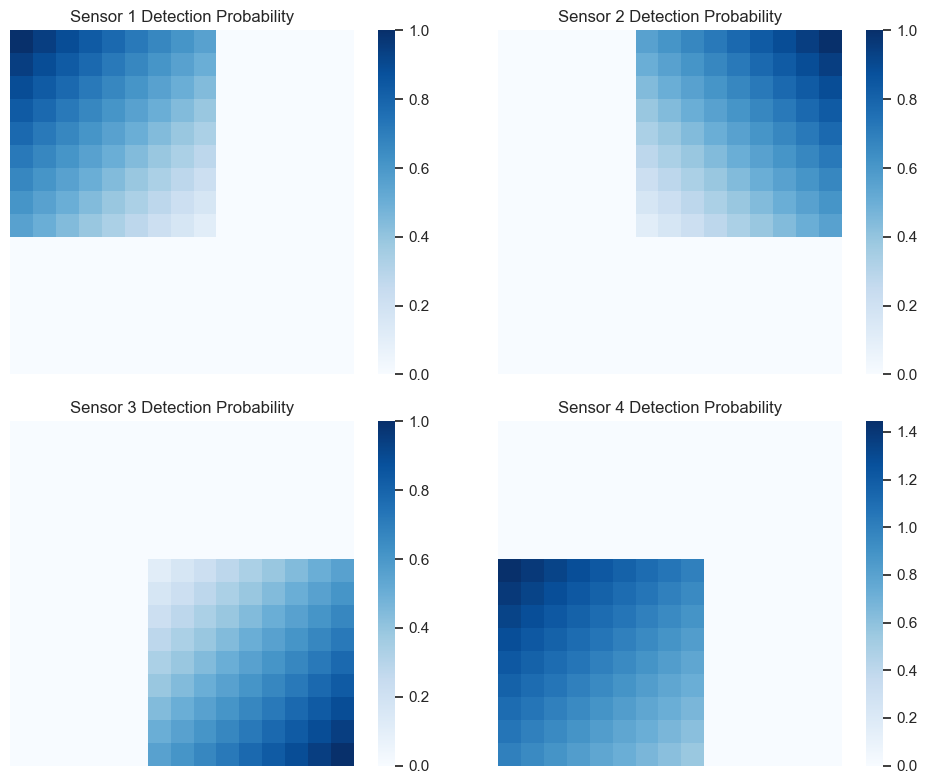

In [81]:
sensor_grids = [np.zeros((15, 15)) for _ in range(4)]

for i in range(1,16):
    for j in range(1,16):
        probabilities = sensor_probabilities(i, j)
        for k in range(4):
            sensor_grids[k][i-1, j-1] = probabilities[k]

fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.set()

for k in range(4):
    sns.heatmap(sensor_grids[k], ax=axes[k//2, k%2], cmap='Blues', annot=False, cbar=True, 
                square=True, xticklabels=False, yticklabels=False)
    axes[k//2, k%2].set_title(f'Sensor {k+1} Detection Probability')

plt.tight_layout()
plt.show()

# Creating the Transition Probabability Matrix

In [100]:
def generate_transition_matrix_from_trajectories(trajectories, grid_size=(15, 15)):
    num_coords = grid_size[0] * grid_size[1]
    transition_matrix = np.zeros((num_coords, num_coords))
    initial_state_probabilities = np.zeros(num_coords)
    final_state_probabilities = np.zeros(num_coords)

    def index_from_coordinate(i, j, grid_size):
        return (i - 1) * grid_size[1] + (j - 1)

    transition_counts = defaultdict(lambda: defaultdict(int))
    state_counts = defaultdict(int)
    initial_state_counts = defaultdict(int)
    final_state_counts = defaultdict(int)

    total_trajectories = len(trajectories)

    for trajectory in trajectories:
        start_index = index_from_coordinate(*trajectory[0], grid_size)
        end_index = index_from_coordinate(*trajectory[-1], grid_size)
        initial_state_counts[start_index] += 1
        final_state_counts[end_index] += 1
        
        for k in range(len(trajectory) - 1):
            (i1, j1) = trajectory[k]
            (i2, j2) = trajectory[k + 1]
            current_index = index_from_coordinate(i1, j1, grid_size)
            next_index = index_from_coordinate(i2, j2, grid_size)
            transition_counts[current_index][next_index] += 1
            state_counts[current_index] += 1

    for current_index, next_states in transition_counts.items():
        total_transitions = state_counts[current_index]
        for next_index, count in next_states.items():
            transition_matrix[current_index][next_index] = count / total_transitions

    for state_index, count in initial_state_counts.items():
        initial_state_probabilities[state_index] = count / total_trajectories

    for state_index, count in final_state_counts.items():
        final_state_probabilities[state_index] = count / total_trajectories

    return transition_matrix, initial_state_probabilities, final_state_probabilities

transition_probability_matrix, initial_state_probabilities, final_state_probabilities = generate_transition_matrix_from_trajectories(trajectories, grid_size=(15, 15))

print("Transition Probability Matrix:")
print(transition_probability_matrix)

print("\nInitial State Probabilities:")
print(initial_state_probabilities)

print("\nFinal State Probabilities:")
print(final_state_probabilities)


Transition Probability Matrix:
[[0.30555556 0.30555556 0.         ... 0.         0.         0.        ]
 [0.13043478 0.39130435 0.26086957 ... 0.         0.         0.        ]
 [0.         0.125      0.4375     ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Initial State Probabilities:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Creating the Observation Probability matrix

In [101]:
def observation_to_index(observation):
    return observation[0] * 8 + observation[1] * 4 + observation[2] * 2 + observation[3]

def generate_observation_probability_matrix(senser_observations, trajectories, grid_size=(15, 15)):
    num_observations = 16 
    num_states = grid_size[0] * grid_size[1]
    
    observation_probability_matrix = np.zeros((num_observations, num_states))
    observation_counts = defaultdict(lambda: defaultdict(int))
    state_counts = defaultdict(int)

    for trajectory, observations in zip(trajectories, senser_observations):
        for state, observation in zip(trajectory, observations):
            i, j = state
            state_index = (i - 1) * grid_size[1] + (j - 1)
            observation_index = observation_to_index(observation)
            observation_counts[state_index][observation_index] += 1
            state_counts[state_index] += 1

    # Calculate the probabilities
    for state_index in range(num_states):
        if state_counts[state_index] > 0:  
            for observation_index in range(num_observations):
                observation_probability_matrix[observation_index][state_index] = (
                    observation_counts[state_index][observation_index] / state_counts[state_index]
                )

    return observation_probability_matrix

observation_probability_matrix = generate_observation_probability_matrix(senser_observations, trajectories, grid_size=(15, 15))

print("Observation Probability Matrix:")
print(observation_probability_matrix)

Observation Probability Matrix:
[[0.         0.04347826 0.1875     ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Row sum in Transition Probability Matrix should be 1 because the probability of transitioning from one state to all other should be 1. Column sum of the Observation Probability Matrix should be 1 since the probability of getting all observations in a given state should be 1.

In [102]:
observation_col_sums = np.sum(observation_probability_matrix, axis=0)
transition_row_sums = np.sum(transition_probability_matrix, axis=1)
print(observation_col_sums)
print(transition_row_sums)

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 

# Likelihood in HMM using Forward Algorithm

In [103]:
def forward_algorithm(trajectory, senser_observations, transition_matrix, observation_matrix, initial_state_probabilities):
    T = len(trajectory) 
    num_states = transition_matrix.shape[0]
    forward_probs = np.zeros((T, num_states))
    initial_probs = initial_state_probabilities
    
    obs_index = observation_to_index(senser_observations[0])
    forward_probs[0] = initial_probs * observation_matrix[obs_index]

    for t in range(1, T):
        obs_index = observation_to_index(senser_observations[t])
        for j in range(num_states):
            forward_probs[t, j] = np.sum(forward_probs[t-1] * transition_matrix[:, j]) * observation_matrix[obs_index, j]

    observation_likelihood = np.sum(forward_probs[T-1, :])

    return observation_likelihood

observation_likelihoods = []

for i in range(20):
    likelihood = forward_algorithm(trajectories[i], senser_observations[i], transition_probability_matrix, observation_probability_matrix, initial_state_probabilities)
    observation_likelihoods.append(likelihood)

for i, likelihood in enumerate(observation_likelihoods):
    print(f"Observation Likelihood for trajectory {i+1}: {likelihood}")

Observation Likelihood for trajectory 1: 4.408736923098082e-17
Observation Likelihood for trajectory 2: 2.548511045460333e-09
Observation Likelihood for trajectory 3: 8.646043455800283e-13
Observation Likelihood for trajectory 4: 1.088682372419606e-06
Observation Likelihood for trajectory 5: 1.1472125349901736e-13
Observation Likelihood for trajectory 6: 6.154505972155134e-14
Observation Likelihood for trajectory 7: 2.9119266102546677e-12
Observation Likelihood for trajectory 8: 5.0538844038763685e-08
Observation Likelihood for trajectory 9: 5.397031896092145e-07
Observation Likelihood for trajectory 10: 6.717314426744151e-06
Observation Likelihood for trajectory 11: 1.378403733912653e-10
Observation Likelihood for trajectory 12: 3.106257634927332e-12
Observation Likelihood for trajectory 13: 1.1158728570155114e-09
Observation Likelihood for trajectory 14: 1.6219564644453562e-11
Observation Likelihood for trajectory 15: 6.332481837876784e-08
Observation Likelihood for trajectory 16: 1.

# Decoding in HMM using Viterbi Algorithm

In [104]:
def index_to_coordinate(index):
    i = (index // 15) + 1
    j = (index % 15) + 1
    return (i, j)

In [105]:
def viterbi_algorithm(observations, transition_matrix, observation_matrix, final_state_probabilities, initial_state_probabilities):
    T = len(observations) 
    num_states = transition_matrix.shape[0] 
    obs_index = observation_to_index(observations[0])
    viterbi_probs = np.zeros((T, num_states))
    backpointers = np.zeros((T, num_states), dtype=int)
    viterbi_probs[0] = initial_state_probabilities * observation_matrix[obs_index]

    for t in range(1, T):
        obs_index = observation_to_index(observations[t])
        for j in range(num_states):
            max_prob, max_state = max(
                (viterbi_probs[t-1, i] * transition_matrix[i, j], i) for i in range(num_states)
            )
            viterbi_probs[t, j] = max_prob * observation_matrix[obs_index, j]
            backpointers[t, j] = max_state

    final_probs = viterbi_probs[T-1] * final_state_probabilities
    best_last_state = np.argmax(final_probs)

    best_path = np.zeros(T, dtype=int)
    best_path[-1] = best_last_state
    for t in range(T-2, -1, -1):
        best_path[t] = backpointers[t+1, best_path[t+1]]

    return best_path

decoded_trajectories = []

for i, observations in enumerate(senser_observations):
    decoded_states = viterbi_algorithm(observations, transition_probability_matrix, observation_probability_matrix, final_state_probabilities, initial_state_probabilities)
    decoded_coordinates = [index_to_coordinate(state) for state in decoded_states]
    decoded_trajectories.append(decoded_coordinates)

for i, decoded in enumerate(decoded_trajectories):
    print(f"Decoded trajectory {i+1}: {decoded}")

Decoded trajectory 1: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 6), (2, 6), (3, 6), (3, 5), (3, 4), (4, 4), (4, 5), (5, 5), (6, 5), (5, 5), (6, 5), (7, 5), (7, 6), (6, 6), (7, 6), (7, 6), (7, 7), (7, 6), (8, 6), (8, 7), (8, 8), (9, 8), (8, 8), (8, 9)]
Decoded trajectory 2: [(1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (1, 4), (1, 5), (1, 6), (1, 6), (1, 5), (1, 6), (2, 6), (3, 6), (3, 5), (4, 5), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (9, 6), (10, 6), (11, 6), (12, 6), (11, 6), (12, 6), (12, 5), (13, 5), (14, 5), (14, 6)]
Decoded trajectory 3: [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 7), (4, 6), (5, 6), (5, 7), (4, 7), (4, 8), (5, 8), (6, 8), (6, 8), (7, 8), (8, 8), (8, 9), (8, 10), (9, 10), (9, 9), (10, 9), (10, 9), (11, 9), (12, 9)]
Decoded trajectory 4: [(1, 1), (1, 2), (1, 2), (1, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5), (6, 5), (5, 5), (6, 5), (7, 5), (7, 6), (8, 6), (9, 6), (10, 6), (11, 6), (12

In [106]:
def plot_trajectory_with_decoded(original_trajectory, decoded_trajectory, grid_size=(15, 15), save_path="compare_trajectories", file_name="trajectory.png"):
    grid = Grid(M=grid_size[0], N=grid_size[1])
    grid.draw_path(original_trajectory, [1, 1, 1])
    grid.draw_path(decoded_trajectory, [1, 0, 1])
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    full_path = os.path.join(save_path, file_name)
    grid.show(full_path)

for idx, (original_trajectory, decoded_trajectory) in enumerate(zip(trajectories, decoded_trajectories)):
    file_name = f"trajectory_{idx+1}_with_decoded.png"
    plot_trajectory_with_decoded(original_trajectory, decoded_trajectory, save_path="compare_trajectories", file_name=file_name)

print("Original and decoded trajectories have been plotted and saved.")


Original and decoded trajectories have been plotted and saved.


Plotting the mean Manhattan Distance between the Original Trajectories and the Decoded Trajectories

In [107]:
def manhattan_distance(coord1, coord2):
    return abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1])

def calculate_mean_manhattan_distance(true_trajectories, predicted_trajectories):
    num_trajectories = len(true_trajectories)
    trajectory_length = len(true_trajectories[0])
    
    mean_distances = np.zeros(trajectory_length)
    for t in range(trajectory_length):
        distances = []
        for i in range(num_trajectories):
            true_state = true_trajectories[i][t]
            predicted_state = predicted_trajectories[i][t]
            distance = manhattan_distance(true_state, predicted_state)
            distances.append(distance)
        mean_distances[t] = np.mean(distances)
    
    return mean_distances

mean_manhattan_distances = calculate_mean_manhattan_distance(trajectories, decoded_trajectories)
print("Mean Manhattan distances at each time step:", mean_manhattan_distances)


Mean Manhattan distances at each time step: [0.   0.5  1.1  1.3  1.55 1.75 2.2  2.3  2.25 2.25 2.75 2.45 2.5  2.3
 2.1  2.   1.65 1.8  1.45 1.3  1.2  1.25 1.35 1.2  1.1  1.1  1.1  1.1
 1.05 1.05]


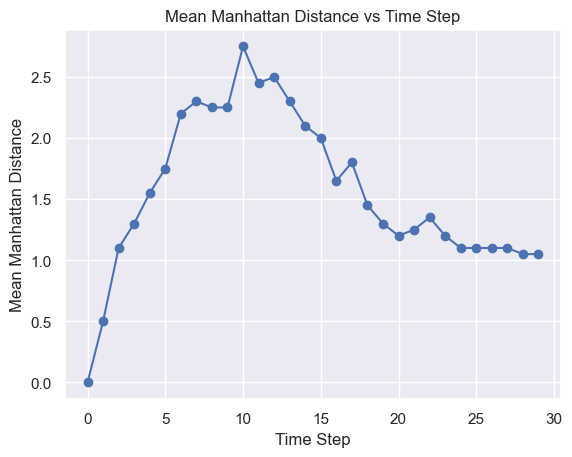

In [108]:
plt.plot(range(len(mean_manhattan_distances)), mean_manhattan_distances, marker='o')
plt.xlabel('Time Step')
plt.ylabel('Mean Manhattan Distance')
plt.title('Mean Manhattan Distance vs Time Step')
plt.grid(True)
plt.show()

# Baum-Welch Algorithm

There is some repeated code to get the Observation sequence of 10000 trajectories of length 20 each and for that I will create that many trajectories, which will be denoted as the original trajectories and find corresponding sensor observations and use them in the implementation of Baum-Welch algorithm.

In [114]:
starting_points = [(1,1)]
original_trajectories = []
for point in starting_points:
    for _ in range(10000):
        trajectory = generate_trajectories(point)
        original_trajectories.append(trajectory)
print(f"Total number of trajectories generated: {len(original_trajectories)}")

Total number of trajectories generated: 10000


In [115]:
all_observations = []
for trajectory in original_trajectories:
    temp_list = []
    for point in trajectory:
        i, j = point
        probabilities = sensor_probabilities(i, j)
        observation = sensor(probabilities)
        temp_list.append(observation)
    all_observations.append(temp_list)
print(f"Total number of observations: {len(all_observations)}")

Total number of observations: 10000


Initialising the Transition probability matrix and the Observation probability matrix

In [112]:
T = np.full((225,225), 1/225)
B = np.full((16,225), 1/16)
pi = np.full(225 , 1 / 225)
original_T, _ , _ = generate_transition_matrix_from_trajectories(original_trajectories, grid_size=(15, 15))
original_B = generate_observation_probability_matrix(all_observations, original_trajectories, grid_size = (15,15))

In [113]:
num_states = 225
num_observations = 16
num_iterations = 20
sequence_length = 20

def observation_to_index(observation_tuple):
    index = 0
    for i, bit in enumerate(observation_tuple):
        index += bit * (2 ** i)
    return index

def calculate_entropy(original_matrix, pred_matrix):
    x = 0
    count = 0
    for i in range(len(original_matrix)):
        for j in range(len(original_matrix[0])):
            if original_matrix[i][j] > 0 and pred_matrix[i][j] > 0:
                x += original_matrix[i][j] * np.log(original_matrix[i][j] / pred_matrix[i][j])
                count += 1
    return x / count

def forward_algorithm(observations, pi, B, T):
    alpha = np.zeros((sequence_length, num_states))
    alpha[0, :] = pi * B[observation_to_index(observations[0]), :]
    for t in range(1, sequence_length):
        for j in range(num_states):
            alpha[t, j] = np.sum(alpha[t - 1, :] * T[:, j]) * B[observation_to_index(observations[t]), j]
        alpha[t, :] /= np.sum(alpha[t, :]) 
    return alpha

def backward_algorithm(observations, B, T):
    beta = np.zeros((sequence_length, num_states))
    beta[sequence_length - 1, :] = 1
    for t in range(sequence_length - 2, -1, -1):
        for i in range(num_states):
            beta[t, i] = np.sum(T[i, :] * B[observation_to_index(observations[t + 1]), :] * beta[t + 1, :])
        beta[t, :] /= np.sum(beta[t, :]) 
    return beta

def baum_welch(all_observations, pi, B, T, original_T):
    kl_divergence_values = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}")
        xi_sum = np.zeros((num_states, num_states))
        gamma_sum = np.zeros((sequence_length, num_states))
        gamma_sum_all = np.zeros(num_states)
        observation_sum = np.zeros_like(B)

        for observations in all_observations:
            alpha = forward_algorithm(observations, pi, B, T)
            beta = backward_algorithm(observations, B, T)

            # E-step: Calculate xi and gamma
            for t in range(sequence_length - 1):
                denom = np.sum(alpha[t, :] * beta[t, :])
                for i in range(num_states):
                    gamma_sum[t, i] += (alpha[t, i] * beta[t, i]) / denom
                    for j in range(num_states):
                        xi_sum[i, j] += (alpha[t, i] * T[i, j] * B[observation_to_index(observations[t + 1]), j] * beta[t + 1, j]) / denom

            gamma_sum[sequence_length - 1, :] += alpha[sequence_length - 1, :] / np.sum(alpha[sequence_length - 1, :])

            for t in range(sequence_length):
                observation_idx = observation_to_index(observations[t])
                for j in range(num_states):
                    observation_sum[observation_idx, j] += gamma_sum[t, j]
                    gamma_sum_all[j] += gamma_sum[t, j]

        # M-step: Update transition probabilities
        new_T = np.zeros_like(T)
        for i in range(num_states):
            for j in range(num_states):
                new_T[i, j] = xi_sum[i, j] / np.sum(gamma_sum[:-1, i])

        new_T /= new_T.sum(axis=1, keepdims=True)

        # M-step: Update observation probabilities
        new_B = observation_sum / gamma_sum_all[None, :]

        kl_divergence = calculate_entropy(original_T, new_T)
        kl_divergence_values.append(kl_divergence)
        print(f"Iteration {iteration + 1}: KL Divergence = {kl_divergence}")
        
        # Update T and B
        T = new_T
        #B = new_B

    return T, B, kl_divergence_values

# Example of running the algorithm
start_time = time.time()

updated_T, updated_B, kld_loss = baum_welch(all_observations, pi, B, T, original_T)

end_time = time.time()

print(f"Total time taken to execute: {end_time - start_time} seconds")
print("KL Divergence values over iterations:")
print(kld_loss)


Iteration 1
Iteration 1: KL Divergence = 1.334805848911362
Iteration 2


KeyboardInterrupt: 